In [1]:
# General imports
import numpy as np
from qiskit import *
# Pre-defined ansatz circuit and operator class for Hamiltonian
from qiskit.circuit.library import EfficientSU2
from qiskit.quantum_info import SparsePauliOp

# SciPy minimizer routine
from scipy.optimize import minimize

# Plotting functions
import matplotlib.pyplot as plt

In [2]:
# runtime imports
from qiskit_ibm_runtime import QiskitRuntimeService, Session
from qiskit_ibm_runtime import EstimatorV2 as Estimator

# # To run on hardware, select the backend with the fewest number of jobs in the queue
# service = QiskitRuntimeService(channel="ibm_quantum")
# backend = service.least_busy(operational=True, simulator=False)
# print(backend)

In [3]:
from qiskit_ibm_runtime.fake_provider import FakeSherbrooke
backend = FakeSherbrooke()

In [4]:
backend.name

'fake_sherbrooke'

## Convención

0 es up y 1 es down

In [5]:
from qiskit.quantum_info import SparsePauliOp

pauli_list = ['ZIII' , 'IZII', 'IIZI', 'IIIZ', 'IIZZ','IZIZ','ZZII','ZIZI']

hamiltonian = SparsePauliOp(pauli_list, [10.0, -1.0, -1.0, -1.0,-1.0,-1.0, 1.0, 1.0])
print(hamiltonian)

#hamiltonian = SparsePauliOp.from_list(
#    [("YZ", 0.3980), ("ZI", -0.3980), ("ZZ", -0.0113), ("XX", 0.1810)]
#)

SparsePauliOp(['ZIII', 'IZII', 'IIZI', 'IIIZ', 'IIZZ', 'IZIZ', 'ZZII', 'ZIZI'],
              coeffs=[10.+0.j, -1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j,  1.+0.j,  1.+0.j])


In [6]:
min_eig_exact = min(np.linalg.eigvalsh(hamiltonian))
print(min_eig_exact)

-17.0


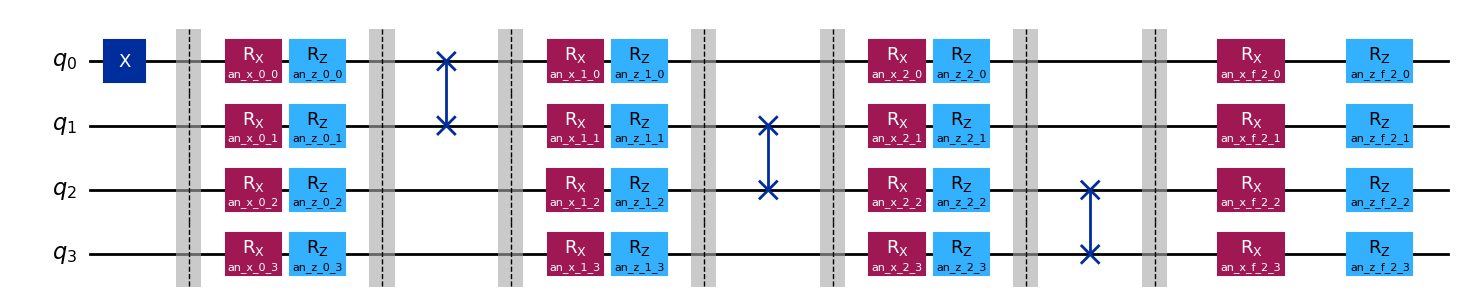

In [7]:
from qiskit.circuit import  Parameter

nqubit=4
qc=QuantumCircuit(nqubit)
c_depth=nqubit-1

qc.x(0)
qc.barrier()
for d in range(c_depth):
    #U_out.add_gate(time_evol_gate)
    
    for i in range(nqubit):
        angle = Parameter(f'an_x_{d}_{i}')#2.0 * np.pi * np.random.rand()
        qc.rx(angle,i)
        angle = Parameter(f'an_z_{d}_{i}')#2.0 * np.pi * np.random.rand()
        qc.rz(angle,i)
    qc.barrier()
    qc.swap(d,d+1)
    qc.barrier()
for i in range(nqubit):
    angle = Parameter(f'an_x_f_{d}_{i}')#2.0 * np.pi * np.random.rand()
    qc.rx(angle,i)
    angle = Parameter(f'an_z_f_{d}_{i}')#2.0 * np.pi * np.random.rand()
    qc.rz(angle,i)    
        
qc.draw("mpl", style="iqp")

In [8]:
num_params = qc.num_parameters
num_params

32

In [9]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)

ansatz_isa = pm.run(qc)

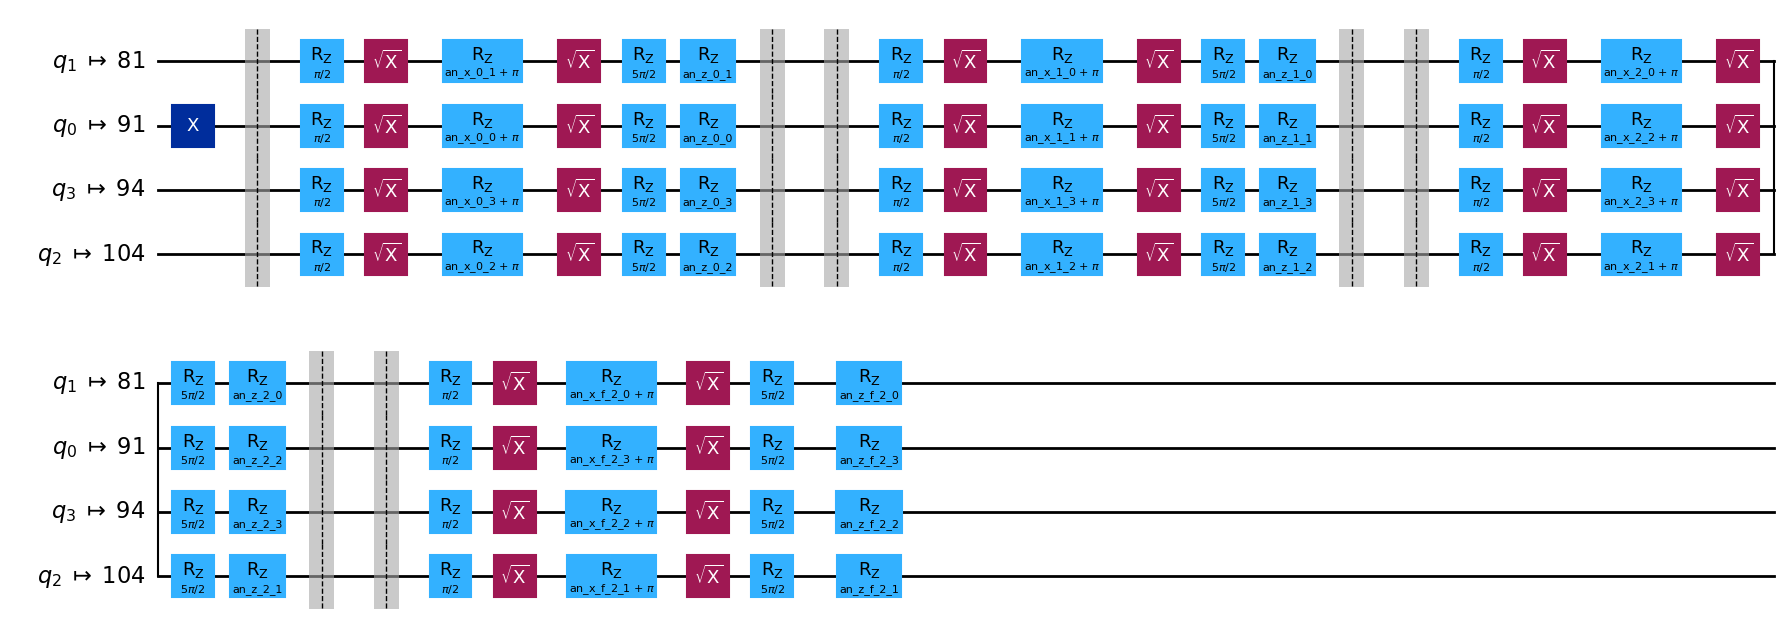

In [10]:
ansatz_isa.draw(output="mpl", idle_wires=False, style="iqp")

In [11]:
hamiltonian_isa = hamiltonian.apply_layout(layout=ansatz_isa.layout)

In [12]:
def cost_func(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (EstimatorV2): Estimator primitive instance
        cost_history_dict: Dictionary for storing intermediate results

    Returns:
        float: Energy estimate
    """
    pub = (ansatz, [hamiltonian], [params])
    result = estimator.run(pubs=[pub]).result()
    energy = result[0].data.evs[0]

    cost_history_dict["iters"] += 1
    cost_history_dict["prev_vector"] = params
    cost_history_dict["cost_history"].append(energy)
    print(f"Iters. done: {cost_history_dict['iters']} [Current cost: {energy}]")

    return energy

In [13]:
cost_history_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}

In [14]:
#x0 = 2 * np.pi * np.random.random(num_params)
x0 = [0 for i in range(num_params)]

In [15]:
backend.name

'fake_sherbrooke'

In [16]:
with Session(backend=backend) as session:
    estimator = Estimator(mode=session)
    estimator.options.default_shots = 200

    res = minimize(
        cost_func,
        x0,
        args=(ansatz_isa, hamiltonian_isa, estimator),
        method="cobyla", options={"maxiter": 50}
    )

Iters. done: 1 [Current cost: -16.51]
Iters. done: 2 [Current cost: -10.66]
Iters. done: 3 [Current cost: -15.460000000000003]
Iters. done: 4 [Current cost: -15.77]
Iters. done: 5 [Current cost: -15.580000000000002]
Iters. done: 6 [Current cost: -15.44]
Iters. done: 7 [Current cost: -10.830000000000002]
Iters. done: 8 [Current cost: -15.440000000000003]
Iters. done: 9 [Current cost: -15.559999999999999]
Iters. done: 10 [Current cost: -15.290000000000001]
Iters. done: 11 [Current cost: -15.620000000000001]
Iters. done: 12 [Current cost: -10.760000000000003]
Iters. done: 13 [Current cost: -15.33]
Iters. done: 14 [Current cost: -15.880000000000003]
Iters. done: 15 [Current cost: -15.76]
Iters. done: 16 [Current cost: -14.830000000000002]
Iters. done: 17 [Current cost: -11.33]
Iters. done: 18 [Current cost: -16.490000000000002]
Iters. done: 19 [Current cost: -16.700000000000003]
Iters. done: 20 [Current cost: -16.7]
Iters. done: 21 [Current cost: -17.0]
Iters. done: 22 [Current cost: -16.8

In [17]:
qc.draw(output="mpl", idle_wires=False, style="iqp")
qc.parameters
opt_parameters = cost_history_dict["prev_vector"]

print(opt_parameters)

[-3.47401647e-03 -6.23541418e-04 -4.39448238e-04 -5.52279542e-04
 -4.08755853e-04 -3.37306215e-03 -4.08755853e-04 -4.57171800e-04
 -2.34292116e-01  3.28659742e-02 -3.41463158e-03  3.28659742e-02
  3.28659742e-02  3.28659742e-02  3.28659742e-02 -3.07613766e-03
  3.28659742e-02  1.03286597e+00  0.00000000e+00  1.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]


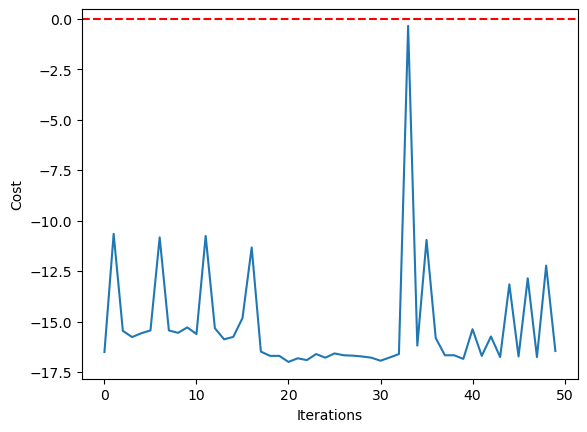

In [18]:
all(cost_history_dict["prev_vector"] == res.x)
cost_history_dict["iters"] == res.nfev
fig, ax = plt.subplots()
ax.plot(range(cost_history_dict["iters"]), cost_history_dict["cost_history"])
ax.axhline(y=0, color='r', linestyle='--', label="Energía objetivo (-1.84)")
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")
plt.draw()

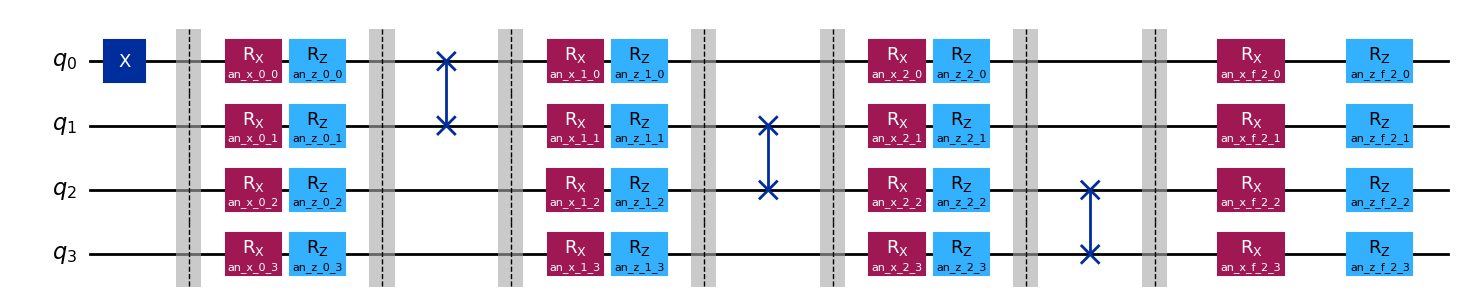

In [19]:
nqubit=4
qc3=QuantumCircuit(nqubit)
c_depth=nqubit-1

qc3.x(0)
qc3.barrier()
for d in range(c_depth):
    #U_out.add_gate(time_evol_gate)
    
    for i in range(nqubit):
        angle = Parameter(f'an_x_{d}_{i}')#2.0 * np.pi * np.random.rand()
        qc3.rx(angle,i)
        angle = Parameter(f'an_z_{d}_{i}')#2.0 * np.pi * np.random.rand()
        qc3.rz(angle,i)
    qc3.barrier()
    qc3.swap(d,d+1)
    qc3.barrier()
for i in range(nqubit):
    angle = Parameter(f'an_x_f_{d}_{i}')#2.0 * np.pi * np.random.rand()
    qc3.rx(angle,i)
    angle = Parameter(f'an_z_f_{d}_{i}')#2.0 * np.pi * np.random.rand()
    qc3.rz(angle,i)    
        
qc3.draw("mpl", style="iqp")

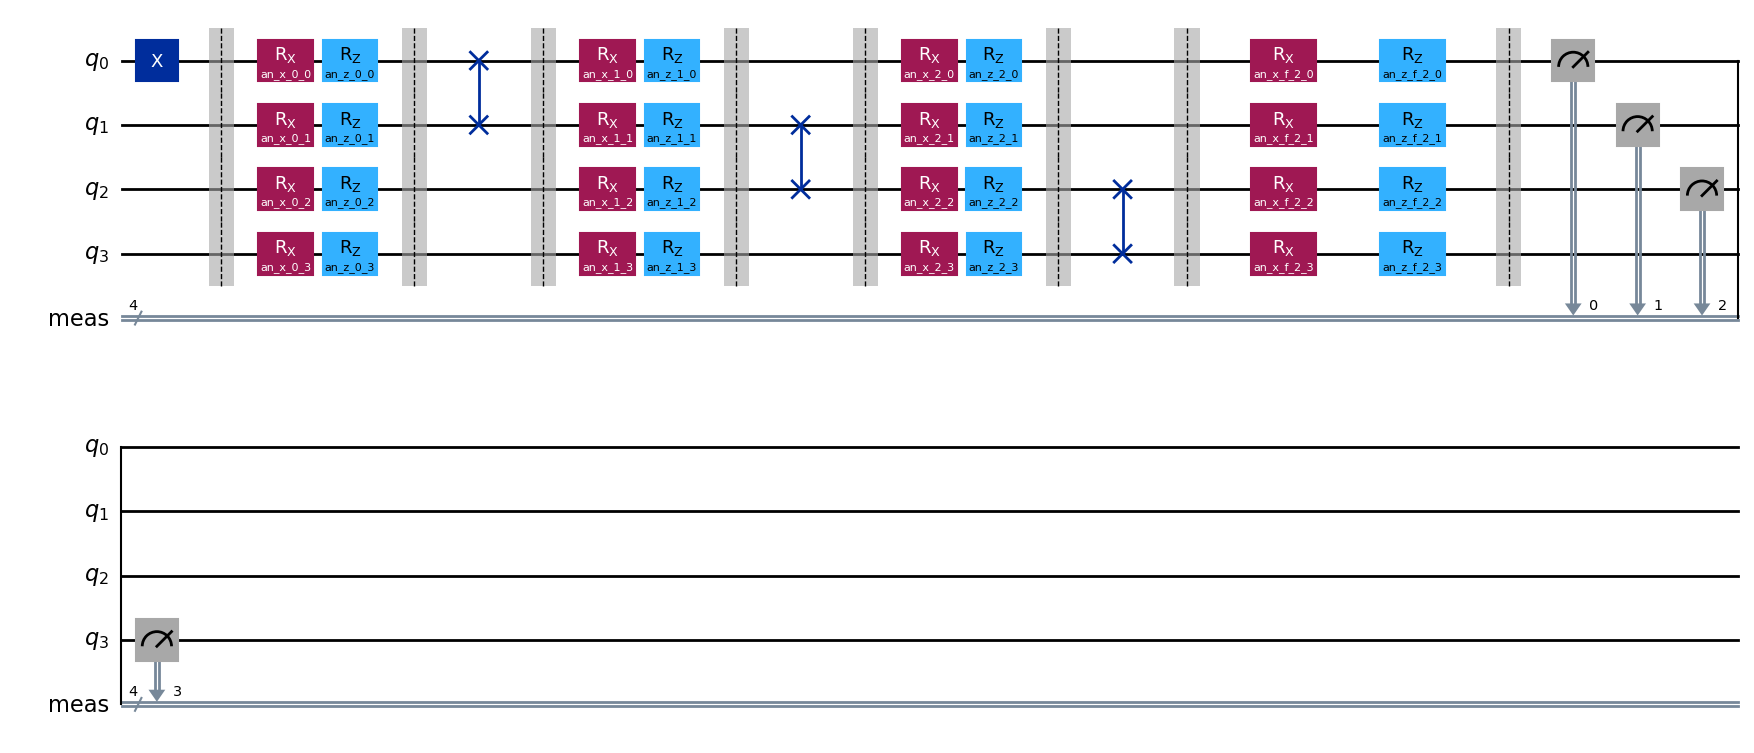

In [20]:
qc3.assign_parameters(opt_parameters)
qc3.measure_all()
qc3.draw("mpl", style="iqp")

/tmp/ipykernel_60494/3538813401.py:4: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  sampler = Sampler(backend=FakeSherbrooke())


{9: 0.0075, 8: 0.9925}


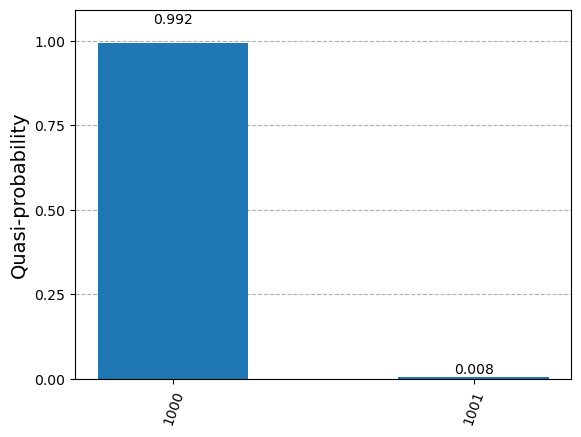

In [21]:
from qiskit_ibm_runtime import SamplerV1 as Sampler
from qiskit.visualization import plot_histogram

sampler = Sampler(backend=FakeSherbrooke())
counts = sampler.run([qc3], [opt_parameters], shots=400).result()
print(counts.quasi_dists[0])
formatted_results = {bin(key)[2:].zfill(qc3.num_qubits): value for key, value in counts.quasi_dists[0].items()}
plot_histogram(formatted_results)

In [22]:
print(qc.parameters)
print(res.x)

ParameterView([Parameter(an_x_0_0), Parameter(an_x_0_1), Parameter(an_x_0_2), Parameter(an_x_0_3), Parameter(an_x_1_0), Parameter(an_x_1_1), Parameter(an_x_1_2), Parameter(an_x_1_3), Parameter(an_x_2_0), Parameter(an_x_2_1), Parameter(an_x_2_2), Parameter(an_x_2_3), Parameter(an_x_f_2_0), Parameter(an_x_f_2_1), Parameter(an_x_f_2_2), Parameter(an_x_f_2_3), Parameter(an_z_0_0), Parameter(an_z_0_1), Parameter(an_z_0_2), Parameter(an_z_0_3), Parameter(an_z_1_0), Parameter(an_z_1_1), Parameter(an_z_1_2), Parameter(an_z_1_3), Parameter(an_z_2_0), Parameter(an_z_2_1), Parameter(an_z_2_2), Parameter(an_z_2_3), Parameter(an_z_f_2_0), Parameter(an_z_f_2_1), Parameter(an_z_f_2_2), Parameter(an_z_f_2_3)])
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]


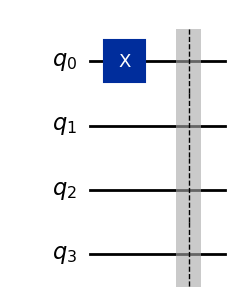

In [23]:
nqubit=4
qc4=QuantumCircuit(nqubit)
c_depth=nqubit-1

qc4.x(0)
qc4.barrier()
# for d in range(c_depth):
#     #U_out.add_gate(time_evol_gate)
    
#     for i in range(nqubit):
#         angle = Parameter(f'an_x_{d}_{i}')#2.0 * np.pi * np.random.rand()
#         qc4.rx(angle,i)
#         angle = Parameter(f'an_z_{d}_{i}')#2.0 * np.pi * np.random.rand()
#         qc4.rz(angle,i)
#     qc4.barrier()
#     qc4.swap(d,d+1)
#     qc4.barrier()
# for i in range(nqubit):
#     angle = Parameter(f'an_x_f_{d}_{i}')#2.0 * np.pi * np.random.rand()
#     qc4.rx(angle,i)
#     angle = Parameter(f'an_z_f_{d}_{i}')#2.0 * np.pi * np.random.rand()
#     qc4.rz(angle,i)    
        
qc4.draw("mpl", style="iqp")

In [24]:
estimator = Estimator(backend=backend)
pub = (qc4, [hamiltonian])

result = estimator.run(pubs=[pub]).result()

print(result[0].data.evs[0])
#formatted_results = {bin(key)[2:].zfill(qc.num_qubits): value for key, value in counts.quasi_dists[0].items()}
#plot_histogram(counts.counts())

/tmp/ipykernel_60494/3309733779.py:1: DeprecationWarning: The 'backend' keyword arguments are deprecated as of qiskit-ibm-runtime 0.24.0 and will be removed no sooner than 3 months after the release date. Please use the 'mode' parameter instead.
  estimator = Estimator(backend=backend)


12.7041015625


In [25]:
pauli_list = ['ZIIZ' ] #, 'IZII', 'IIZI', 'IIIZ']

hamiltonian = SparsePauliOp(pauli_list, [1.0]) #, 0.0, 1.0, 1.0])
print(hamiltonian)

SparsePauliOp(['ZIIZ'],
              coeffs=[1.+0.j])
